In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#probably a better prewritten function exists somewhere...
def grayscale(imgnp, contrast = True):
    dim = imgnp.shape[-1]
    avg = lambda arr: sum(arr[0:3])/3
    if dim>=3:
        downscaled = np.array([[avg(imgnp[i][j])/255 for j in range(imgnp.shape[1])] for i in range(imgnp.shape[0])])
    
    else:
        downscaled = imgnp
    
    if contrast:
        for i in range(downscaled.shape[0]):
            for j in range(downscaled.shape[1]):
                if downscaled[i,j]<0.2:
                    downscaled[i,j] = 0
        return downscaled
    
    return downscaled

In [3]:
#functions needed for level set method, written earlier
#TODO: make a script for utility functions like this for easy import 
def showsurf(surface, ls=False):
    fig = plt.figure(figsize=(10,10))

    x = np.linspace(0, surface.shape[1]-1, surface.shape[1])
    y = np.linspace(0, surface.shape[0]-1, surface.shape[0])

    X,Y = np.meshgrid(x,y)
    
    if not ls:
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X,Y,surface)
    if ls:
        plt.contour(X,Y,surface, [0])

def organize(c):
    c.sort(key = lambda x: x[0])
    ordered = []
    ordered.append(c[0])
    c.remove(ordered[0])
    
    d = lambda x,y: ((x[0]-y[0])**2+(x[1]-y[1])**2)
    
    while(len(c)> 0):
        c.sort(key=lambda x: d(x,ordered[-1]))
        ordered.append(c[0])
        c.remove(ordered[-1])
    
    #check orientation
    if ordered[0][1]<ordered[1][1]:
        ordered.reverse()
    
    return ordered

def k(s):
    '''
    curvature given as divergence of the unit normal 
    
    returns a 2d array of curvature vals at each iter?
    '''
    sy, sx = np.gradient(s)
    norm = (sx**2 + sy**2)**0.5
    nx = sx/(norm+0.00001)
    ny = sy/(norm+0.00001)
    
    nxy, nxx = np.gradient(nx)
    nyy, nyx = np.gradient(ny)
    
    return nxx+nyy

def mean_curvature(Z):
    Zy, Zx  = np.gradient(Z)
    Zxy, Zxx = np.gradient(Zx)
    Zyy, _ = np.gradient(Zy)

    H = (Zx**2 + 1)*Zyy - 2*Zx*Zy*Zxy + (Zy**2 + 1)*Zxx
    H = -H/(2*(Zx**2 + Zy**2 + 1)**(1.5))

    return H


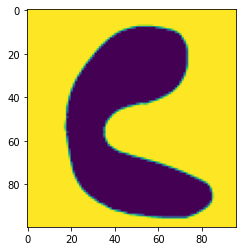

In [57]:
#we're going to try to segment the following image...
img = Image.open('blob.png')
img.thumbnail((100,100))
img = np.array(img)
gimg = grayscale(img)
plt.imshow(gimg)

In [58]:
#make that image a tad larger with whitespace
def addWhite(image, pxr = 0.25):
    '''
    adds additional white space to a contrasted image, assume generic blob in center. 
    '''
    vert = int(pxr*image.shape[0])
    horz = int(pxr*image.shape[1])
    
    newimg = np.ones((image.shape[0]+2*vert, img.shape[1]+2*horz))
    #now fill with original stuff 
    newimg[vert:(vert+image.shape[0]), horz:(horz+image.shape[1])] = image
    
    return newimg

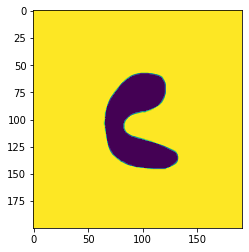

In [59]:
gimg = addWhite(gimg, pxr=0.5)
plt.imshow(gimg)

now try to implement functional with color and arc length terms 

In [60]:
#function for parabloid whose contour spans some percentage of the target image area, option for centering?
#maybe add skew for elipses generation (modification of mesh size in one direction)
def parabloid(shape, radiusPercentage=0.6, mesh = 0.01):
    ydim = shape[0]
    xdim = shape[1]
    
    #this logic is important when x and y dim are different so that we have constant step size in both directions 
    x = np.linspace(-(xdim/2)*mesh, (xdim/2)*mesh, xdim)
    y = np.linspace(-(ydim/2)*mesh, (ydim/2)*mesh, ydim)
    xx, yy = np.meshgrid(x,y)
    
    #compute scaling factor such that surf takes value 1 at radiusPercentage*min(xdim,ydim)//2
    if min(xdim,ydim) == xdim:
        alpha = 1/(((xdim//2)*radiusPercentage*mesh)**2)
    else:
        alpha = 1/(((ydim//2)*radiusPercentage*mesh)**2)
    
    return -alpha*(xx**2+yy**2)+1


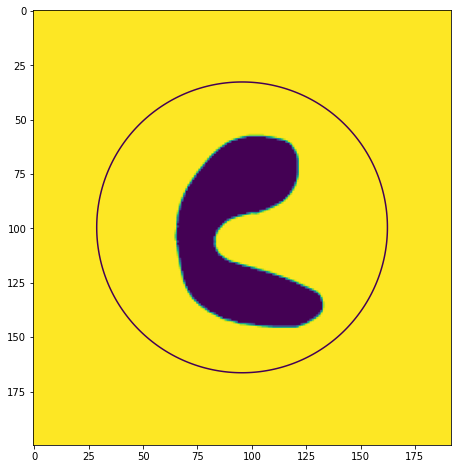

In [61]:
#see if this thing works, mess around with radiusPercentage to change how wide the circle is 
z = parabloid(gimg.shape, radiusPercentage=0.7)
plt.figure(figsize=(8,8))
plt.contour(z, [0])
plt.imshow(gimg)

In [62]:
def iteration(surface, image, dt=0.001, alpha = 1):
    d = lambda x,y: (x**2 + y**2)**0.5

    sy, sx = np.gradient(surface)
    nx = sx/(d(sx,sy)+0.0001)
    ny = sy/(d(sx,sy)+0.0001)

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = mean_curvature(surface)

    #now the evolution function:
    F1 = K
    F2 = (image)**2 - (image - np.ones(image.shape))**2

    surface = surface - (F2+alpha*F1)*d(sx,sy)*dt

    return surface

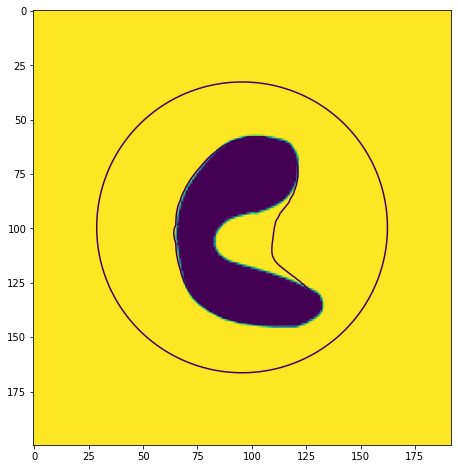

In [63]:
g = z

#takes 3ish minutes on my computer, increase num iterations and it will get closer to surrounding the blob
for i in range(60000):
    g = iteration(g, gimg, dt=0.001, alpha=75)

plt.figure(figsize=(8,8))
plt.contour(g, [0])
plt.contour(z,[0])
plt.imshow(gimg)